# SMS Spam Detection using TensorFlow 

## Step 1: Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub


## Step 2: Load the Dataset

In [2]:
df = pd.read_csv("spam.csv")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Step 3: Clean the dataset and encode labels

In [3]:
# Use the exact column names with a space after the colon
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Rename the remaining columns
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})

# Create the encoded label column
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})

# Show the result
print(df.head())
print("\nDataFrame shape:", df.shape)
print("Columns:", df.columns.tolist())

  label                                               Text  label_enc
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0

DataFrame shape: (5572, 3)
Columns: ['label', 'Text', 'label_enc']


## Step 4: Split Data and convert to NumPy arrays

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42
)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

## Step 5: Compute text Statistics for Vectorization

In [5]:
avg_words_len = round(sum([len(i.split())
                      for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(X_train_np)}")
print(f"Average words per message: {avg_words_len}")
print(f"Approximate vocabulary size: {total_words_length}")

Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


## Step 6: Helper functions for training and evaluation

In [6]:
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=epochs,
        validation_data=(X_test_np, y_test_np)
    )
    return history

def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1-score': f1_score(y, y_preds)
    }

## Step 7: Create the TextVectorization layer

In [7]:
from tensorflow.keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)
text_vec.adapt(X_train_np)

## Step 8: Model 1 – Dense embedding model (build and train)

In [8]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name="Dense_Model")
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9094 - loss: 0.2790 - val_accuracy: 0.9587 - val_loss: 0.1426
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9785 - loss: 0.0853 - val_accuracy: 0.9749 - val_loss: 0.0762
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9892 - loss: 0.0409 - val_accuracy: 0.9767 - val_loss: 0.0672
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9948 - loss: 0.0254 - val_accuracy: 0.9767 - val_loss: 0.0652
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9969 - loss: 0.0152 - val_accuracy: 0.9785 - val_loss: 0.0654


## Step 9: Model 2 – Bidirectional LSTM model (build and train)

In [9]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name="BiLSTM_Model")
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9399 - loss: 0.1835 - val_accuracy: 0.9713 - val_loss: 0.0884
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9886 - loss: 0.0455 - val_accuracy: 0.9785 - val_loss: 0.0701
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9962 - loss: 0.0166 - val_accuracy: 0.9803 - val_loss: 0.0915
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 0.9776 - val_loss: 0.0904
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9998 - loss: 6.5380e-04 - val_accuracy: 0.9812 - val_loss: 0.1012


## Step 10: Model 3 – Transfer learning with Universal Sentence Encoder (build and train)

In [15]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(
    x), output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(input_layer, output_layer, name="USE_Model")
history_3 = compile_and_fit(model_3)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9293 - loss: 0.2684 - val_accuracy: 0.9713 - val_loss: 0.1028
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9785 - loss: 0.0776 - val_accuracy: 0.9785 - val_loss: 0.0679
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9841 - loss: 0.0551 - val_accuracy: 0.9830 - val_loss: 0.0577
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9870 - loss: 0.0457 - val_accuracy: 0.9839 - val_loss: 0.0538
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9897 - loss: 0.0380 - val_accuracy: 0.9848 - val_loss: 0.0518


## Step 11: Collect performance metrics for all models

In [14]:
results = {
    'Dense Embedding': get_metrics(model_1, X_test_np, y_test_np),
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print("Performance Table:")
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Performance Table:
                         accuracy  precision    recall  f1-score
Dense Embedding          0.978475   0.956204  0.879195  0.916084
Bi-LSTM                  0.981166   0.944444  0.912752  0.928328
Transfer Learning (USE)  0.984753   0.964789  0.919463  0.941581


## Step 12: Visualize

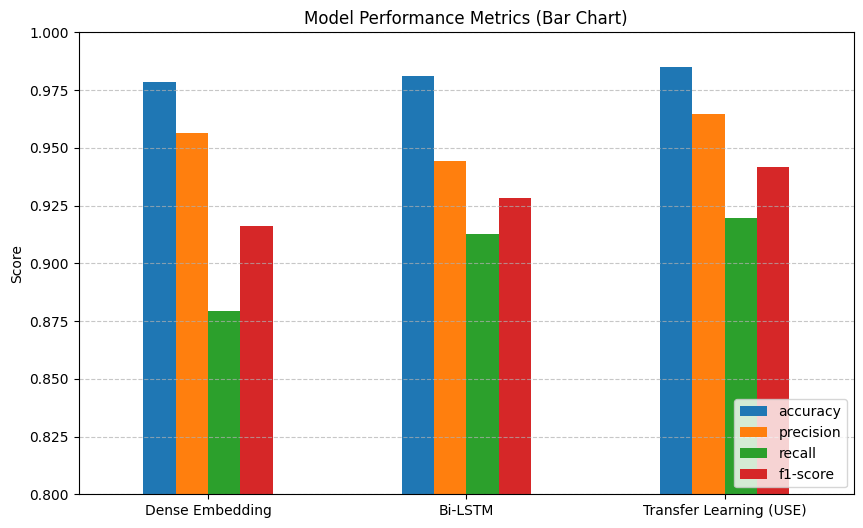

In [12]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

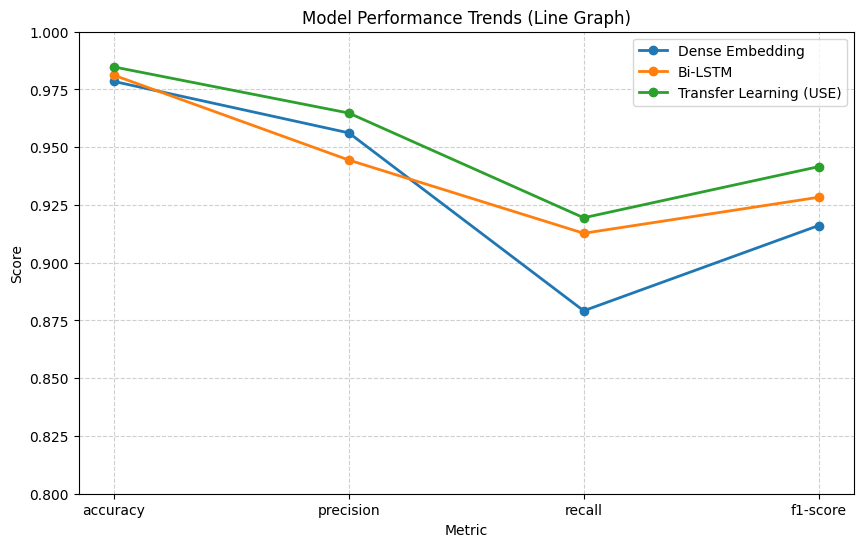

In [13]:
plt.figure(figsize=(10, 6))

for model_name in results_df.index:
    plt.plot(
        results_df.columns,
        results_df.loc[model_name],
        marker='o',
        label=model_name,
        linewidth=2
    )
plt.title("Model Performance Trends (Line Graph)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()